analyze NCI cervical cnv results

example cnv file: 
/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-03-06-02242/hg19a/GSH/A57097_A56625/cnv/tc_50/25662/results/apolcnv_out_segs_annotated.txt

it looks like in the annotation file, cnv state column
0= Ncnv, Acnv, Dcnv
1=HET,ASCNA
2=BCNA

so my objective is to pull out all those genes in the annotation file with a cnv state = 0

In [1]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25


# look for ways to clean up our cnvseq copy nunmber results

1. eliminate super small segments called for example 3kb or even 10kb
2. mask blacklisted non-diploid regions when segments length < threshold, for example 1Mb,this should take into consideration of segments flanking the segment, e.g. a:3copies, b: 4:copies, c: 3copies. although b is short but abc are all amplified, 4 copies may not accurate, but there is a gain for sure. in this case, b will be marked as 3.
3. also for those over-segmented cases, i may need to do something as well.??



In [259]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt'
df1 = pd.read_csv(f1, sep='\t', header=None, comment='#')
df1.columns = ['patient', 'seg_path']
assert df1.shape[0] == 123
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...
1,HTMCP-03-06-02002,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...


In [260]:
df2 = pd.DataFrame()
for idx, row in df1.iterrows():
    pat = row['patient']
    seg_file = row['seg_path']
#     print(pat, seg_file)
    # cnv_files, some rows have 10 columns instead of 9, problems from the APLcnv pipeline
    cnv = pd.read_csv(seg_file, sep='\t',  error_bad_lines=False, warn_bad_lines=True)
    cnv.columns = ['chr', 'start', 'end', 'cn']
    cnv = cnv[cnv.cn != 2]
    cnv['patient'] = pat
    if df2.empty:
        df2 = cnv
    else: df2 = pd.concat([df2,cnv])

In [261]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [262]:
df2.shape

(49750, 5)

In [263]:
df2['seg_length'] = df2.end - df2.start

In [264]:
df2.head(2)

,chr,start,end,cn,patient,seg_length
0,1,416575,564606,4,HTMCP-03-06-02001,148031
1,1,564607,569345,1,HTMCP-03-06-02001,4738


In [267]:
df2[df2.seg_length < 3000].shape

(2290, 6)

In [ ]:
# non-diploid segments per patient
segments = df2.groupby('patient').count().sort_values('cn', ascending=False)['cn']

In [270]:
segments.head(2)

patient
HTMCP-03-06-02109    2010
HTMCP-03-06-02157    1355
Name: cn, dtype: int64

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


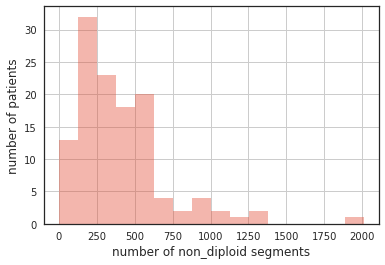

In [268]:
# distribution of number of segments
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w')
    sns.distplot(segments, kde=False)
    plt.xlabel('number of non_diploid segments')
    plt.ylabel('number of patients')

In [271]:
df2.groupby(['chr', 'start', 'end']).count().sort_values('patient', ascending=False).shape

(49733, 3)

In [272]:
df2.head()

,chr,start,end,cn,patient,seg_length
0,1,416575,564606,4,HTMCP-03-06-02001,148031
1,1,564607,569345,1,HTMCP-03-06-02001,4738
2,1,569346,722466,4,HTMCP-03-06-02001,153120
3,1,722467,831517,3,HTMCP-03-06-02001,109050
4,1,831518,1487296,4,HTMCP-03-06-02001,655778


In [51]:
# of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps.txt'
# of2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels.txt'
# # df2[df2.cn >2].to_csv(of, index=False, header=None, sep='\t')
# df2[df2.cn <2].to_csv(of2, index=False, header=None, sep='\t')

In [250]:
patients = df2.patient.value_counts().index.tolist()

In [188]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df3 = pd.read_csv(f3, header=None, sep='\t')
df3.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df3.head()

,chr,start,end,cytoband,comments
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5400000,p36.32,gpos25
2,chr1,5400000,7200000,p36.31,gneg
3,chr1,7200000,9200000,p36.23,gpos25
4,chr1,9200000,12700000,p36.22,gneg


In [11]:
# df3[df3.chr=='chr1']

look at GISTIC amp and del peak length distribution

In [189]:
# generate 3 million bins for the whole genome
f1 = '/home/szong/projects/resource/chrominfo.txt'
chrominfo = pd.read_csv(f1, sep='\t', index_col='#chrom')
chrominfo.columns = ['size', 'file_name']
chrominfo.head(2)

,size,file_name
#chrom,,
chr1,249250621,/gbdb/hg19/hg19.2bit
chr2,243199373,/gbdb/hg19/hg19.2bit


In [14]:
# of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
# with open(of,  'w') as fh:
#     writer = csv.writer(fh, delimiter='\t')
#     for i in np.arange(1, 23):
#         chr = 'chr{}'.format(i)

#         # ignoring the chromosome 1kb tail for now   
#         chr_size = chrominfo.loc[chr, 'size']
#         stride = 1000
#         bin1 = np.arange(1, chr_size, stride)
#         bin2 = np.arange(stride, chr_size+stride, stride)
#         bin_len = min(len(bin1), len(bin2))
#         bin1 = bin1[:bin_len]
#         bin2 = bin2[:bin_len]
#         bins = list(zip([i]*len(bin1), bin1, bin2))




#         for item in bins:
#             writer.writerow(item)
# need to use this line to remove special character
# cat chr_bins.txt|sed $'s/[^[:print:]\t]//g' >b.tmp 

find systematic cnv noise

In [191]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb.txt'
# df = pd.read_csv(f, sep='\t', header=None)
# df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
# occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
# recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb_patients.txt'
recur_amps.to_csv(f, index=False, sep='\t')
recur_amps = pd.read_csv(f, sep='\t')

In [192]:
recur_amps.head(2)

,bin_chr,bin_start,bin_end,patient
0,1,10001,11000,1
1,1,11001,12000,1


In [ ]:
# recur_amps.patient.reset_index().drop('index', axis=1).plot()

figure out how many patients having deletions in each bin

/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a chr_bins.txt -b dels.txt.sorted -wa -wb > dels_bins_1kb.txt

In [193]:
# f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_bins_1kb.txt'
# df = pd.read_csv(f, sep='\t', header=None)
# df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
# occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
# recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_bins_1kb_patients.txt'
recur_dels.to_csv(f, index=False, sep='\t')
recur_dels = pd.read_csv(f, sep='\t')

In [194]:
df2.head(2)

,chr,start,end,cn,patient
0,1,416575,564606,4,HTMCP-03-06-02001
1,1,564607,569345,1,HTMCP-03-06-02001


In [195]:
df3.head(2)

,chr,start,end,cytoband,comments
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5400000,p36.32,gpos25


In [197]:
# patients

In [ ]:
# plot cytoband hg19
df_segs = df2.copy()
df_cytoband = df3.copy()

In [255]:
patients = ['HTMCP-03-06-02071', 'HTMCP-03-06-02330', 'HTMCP-03-06-02441']

processing chr 1 and the chr_offset is 0
plotting amp aggregation


/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


plotting del aggregation


/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


processing chr 2 and the chr_offset is 249250621
plotting amp aggregation
plotting del aggregation
processing chr 3 and the chr_offset is 492449994
plotting amp aggregation
plotting del aggregation
processing chr 4 and the chr_offset is 690472424
plotting amp aggregation
plotting del aggregation
processing chr 5 and the chr_offset is 881626700
plotting amp aggregation
plotting del aggregation
processing chr 6 and the chr_offset is 1062541960
plotting amp aggregation
plotting del aggregation
processing chr 7 and the chr_offset is 1233657027
plotting amp aggregation
plotting del aggregation
processing chr 8 and the chr_offset is 1392795690
plotting amp aggregation
plotting del aggregation
processing chr 9 and the chr_offset is 1539159712
plotting amp aggregation
plotting del aggregation
processing chr 10 and the chr_offset is 1680373143
plotting amp aggregation
plotting del aggregation
processing chr 11 and the chr_offset is 1815907890
plotting amp aggregation
plotting del aggregation
pr

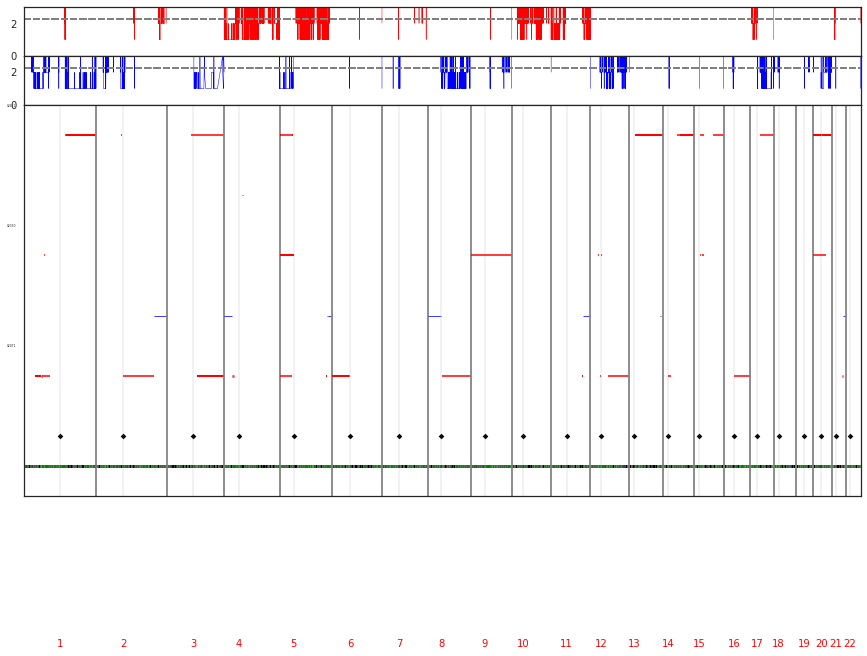

In [258]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
#     fig = plt.figure(facecolor='w', figsize=(15,9))
    fig = plt.figure(figsize=(15, 9), facecolor='white')
    gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,8],
                           wspace=0.05, # horizontal space
                           hspace=0.0  # vertical space
                          )
    
    ax0 = fig.add_subplot(gs[0], facecolor='white')
    ax1 = fig.add_subplot(gs[1], facecolor='white')
    ax2 = fig.add_subplot(gs[2], facecolor='white')
    chr_offset = 0 # chromosome offset
    num_patients = len(patients)
#     ylim = 4
    ylim = num_patients/10.0+0.1
    for chr in np.arange(1,23):
        print('processing chr {0} and the chr_offset is {1}'.format(chr, chr_offset))
        dfchr = df_cytoband[df_cytoband.chr=='chr{}'.format(chr)]
        clrs = ['-k', '-g']*100
        
        num_segs = dfchr.shape[0]
        # plot centromere
        acen = dfchr[dfchr.comments=='acen'].reset_index().loc[0, 'end'] + chr_offset
        ax2.plot(acen, 0.1, color='black',marker='D', markersize=4)
        ax2.axvline(x=acen, color='gray', linewidth=0.2)
        ax2.text(acen, -.25, '{}'.format(chr), color='red', horizontalalignment='center')
        
        clrs = clrs[:num_segs]
        i = 0 # color index
        for idx, row in dfchr.iterrows():
            start = row.start + chr_offset
            end = row.end + chr_offset
            cytoband = row.cytoband
            comment = row.comments
            center = (start + end)/2 + chr_offset
            width = int(end - start)
            ax2.plot((start, end), (0.05,0.05), clrs[i], linewidth=3, solid_capstyle='butt')        
            i+=1

        
        # draw chromosome boundary
        ax2.axvline(x=chr_offset, color='gray')
        
        
        # plot amp aggregate results
        amps = recur_amps.query('bin_chr == {0}'.format(chr))
        print('plotting amp aggregation')
        amps['x'] = amps.bin_start + chr_offset
        ax0.plot(amps.x, amps.patient, color='red', linewidth=.5, solid_capstyle='butt')
        ax0.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')

        # plot del aggregate results
        dels = recur_dels.query('bin_chr == {0}'.format(chr))
        print('plotting del aggregation')
        dels['x'] = dels.bin_start + chr_offset
        ax1.plot(dels.x, dels.patient, color='blue', linewidth=.5, solid_capstyle='butt')
        ax1.axhline(y=0.75*num_patients, color='gray', linestyle='dashed')
 
       
        # plot cnvs
        j = 0 # row offset
        yticks = []
        cnvy_coords = []
        for patient in patients: 
#             print('plotting patient {0}, cnvy_coords is {1}'.format(patient, 0.2+j))
            # plot amplification
            amps = df_segs.query('chr == {0} & patient == "{1}" & cn > 2'.format(chr, patient))
            m=0 #test label offset to be deleted
            for idx, row in amps.iterrows():
                start = row.start + chr_offset
                end = row.end + chr_offset
                length = end - start
                cn = row.cn
#                 if chr == 7 or chr ==14:
#                     print('plotting amps line {0}:{1}-{2}, cn {3}, length {4}'.format(chr, row.start, row.end, cn, row.end-row.start))
                    

#                 it looks like can not see anything <150000 on a 3 billion scale, so magnfiy anything to 150000
                if length < 200000:
                    end = start + 200000
                ax2.plot((start, end), (0.2+j, 0.2+j), color='red', marker='_', linewidth=cn*0.5, solid_capstyle='butt')
#                 ax2.text(start, 0.2+m, str(row.start))
#                 m+=0.2
            # plot deletion
            dels = df_segs.query('chr == {0} & patient == "{1}" & cn < 2'.format(chr, patient))
            for idx, row in dels.iterrows():
                start = row.start + chr_offset
                end = row.end + chr_offset
                length = end - start
                cn = row.cn
                if length < 200000:
                    end = start + 200000
                del_w = 2 - cn
                ax2.plot((start, end), (0.3+j, 0.3+j), color='blue', marker='_', linewidth=del_w*0.75, solid_capstyle='butt')
            yticks.append(0.25+j)
            j+=0.2
        chr_offset+=max(dfchr.end)
    ax0.set_xlim(0, chr_offset)
    ax0.set_ylim(0, num_patients)
    ax1.set_xlim(0, chr_offset)
    ax1.set_ylim(0, num_patients)
    ax2.set_xlim(0, chr_offset)
    ax2.set_ylim(0, ylim)
    ax0.set_xticklabels('')
    ax1.set_xticklabels('')
    ax2.set_xticklabels('')
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([i.split('-')[3] for i in patients], fontsize=3)
#     plt.tight_layout()
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_123_patients.png'
    plt.savefig(of, dpi=800)
    plt.show()

In [ ]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
df.head(2)

occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)

occurrence.head()

type(occurrence.reset_index())

recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])

recur_amps.head()

f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_bins_1kb_patients.txt'
recur_amps.to_csv(f, index=False, sep='\t')

sanity check: because of resolution, bands less than 100kb in length may not show on the plot.

    while read a b;do echo -ne $a"\t";/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b -b a.tmp ;done < Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt |awk '$5>2'

 these are 3 examples of peaks in 7q14.1, we should see them in the plot
 while read a b;do echo -ne $a"\t";/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a $b -b 7q14.1_peak_coords.txt -wa -wb;done < cnv_files_for_acen_removal.txt|grep "02441\|02330\|02071"
 
HTMCP-03-06-02071	7	38294085	38374669	4	7	38311127	38338695

HTMCP-03-06-02330	7	38309671	38338696	4	7	38311127	38338695

HTMCP-03-06-02441	7	38292804	38368824	4	7	38311127	38338695


clean up by masking GISTIC wide peaks after review and black listed regions

In [ ]:
# peak region to remove: my scipts identified
# 6	58776001	58780001	4000
# 7	38294001	38371001	77000
# 14	22406001	22971001	565000

# GISTIC wide peaks
# chr14:22779419-22934657	
# chr7:38311127-38338695	
# chr7:142421419-142476036
# chr4:68264255-68264791



In [75]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/peaks_to_remove.txt'
df3 = pd.read_csv(f3, comment="#", sep='\t', header=None)
df3.columns= ['chr', 'start', 'end', 'length']
df3

,chr,start,end,length
0,6,58776001,58780001,4000
1,14,22779419,22934657,155238
2,7,38311127,38338695,27568
3,7,142421419,142476036,54617
4,4,68264255,68264791,536


In [348]:
f3_1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv/amps_noise_to_review.txt'
amp_noise = pd.read_csv(f3_1, sep='\t', header=None)
amp_noise.columns = ['chr', 'start', 'end', 'length', 'cytoband']
amp_noise.head(2)

,chr,start,end,length,cytoband
0,1,143118001,143293001,175000,1q21.1
1,1,143645001,144221001,576000,1q21.1


In [349]:
f3_2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/pog_cnv/dels_noise_to_review.txt'
del_noise = pd.read_csv(f3_2, sep='\t', header=None)
del_noise.columns = ['chr', 'start', 'end', 'length', 'cytoband']
del_noise.head(2)

,chr,start,end,length,cytoband
0,1,143349001,143545001,196000,1q21.1
1,2,92290001,92293001,3000,2p11.1


In [ ]:
# rules to clean up for both amps and dels
# overlap 10% of the interval to be masked
# if cn>2 and if neighbouring segments amplified as well, len(segment_minus1, segment, segment_plus1) > 1mb,change to neighbouring cn, otherwise change the cn to 2
# if cn <2 and if neighbouring segments deleted as well, len(segment_minus1, segment, segment_plus1) > 1mb, change to neighboruing cn, change to 2

In [76]:
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...
1,HTMCP-03-06-02002,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...


In [279]:
def overlap_intervals(a, b):
    overlap = max(0, min(a[1], b[1]) - max(a[0], b[0]))
    return overlap


In [282]:
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...
1,HTMCP-03-06-02002,/projects/somatic/NCI_SAIC_HIV_Cervical/HTMCP-...


In [552]:
# shortest chromosome 21 = ~48Mb
normal_cn = 2 # assuming diploid
len_threshold = 3000 # reliable focal cnv length called by cnvseq
combined_length = 1e6 # length of amplified or deleted combining neighouring amps or dels
overlap_threshold = 0.1 # >10% overlap with noise region to be considered masking

In [553]:
def find_neighbour_segs(seg_arr, seg_idx):
    if seg_idx == 0:
        arr = seg_arr[ :seg_idx+2, ]
    elif seg_idx == len(seg_arr)-1: 
        arr = seg_arr[seg_idx-1: , ]
    else:
        arr = seg_arr[seg_idx-1 : seg_idx+2, ]
    
    # only merge the same chromosome
    chr = seg_arr[seg_idx, 0]
    ix, = np.where(arr[:, 0] == chr)
    arr = arr[ix,]
    return arr

In [554]:
def adj_length_cn(seg_arr, seg_idx, cn):   
    arr = find_neighbour_segs(seg_arr, seg_idx)
    if cn > normal_cn: 
        idx,  = np.where(arr[:, 3] > normal_cn)
        adj_cn = min(arr[idx, 3])
    elif cn < normal_cn:
        idx, = np.where(arr[:, 3] < normal_cn)
        adj_cn = max(arr[idx, 3])
    seg_len = sum(arr[idx, 4])
    return (seg_len, adj_cn)

In [560]:
def assign_cn_on_length(seg_len, adj_cn):
    if seg_len > combined_length:
#         print('change cn to {}'.format(adj_cn))
        cn = adj_cn
    else: 
#         print('change cn to {}'.format(normal_cn))
        cn = normal_cn
    return cn

In [564]:

def mask_false_cnv(df_segs, amp_noise, del_noise, of):    
    with open(of, 'w') as writer:
        segs = df_segs.values
        num_segs = len(segs)
        for i, seg in enumerate(segs):
#             print(i, seg)
            chrm, start, end, cn, seg_len_tmp = seg
            length = end - start
            amp_chrms = amp_noise.chr.unique()
            del_chrms = del_noise.chr.unique()
            if length < len_threshold and cn != normal_cn:                
                seg_len, adj_cn = adj_length_cn(segs, i, cn)
                cn = assign_cn_on_length(seg_len, adj_cn)
                print('{0}<3kb, merge to neighbouring segment, change cn to {1}'.format(seg, cn))
            elif chrm in amp_chrms and cn > normal_cn: # m_: to mask
#                 print('ampaaaaaaaa')
                for j, m_row in amp_noise.iterrows():
                    m_chrm, m_start, m_end, m_len_tmp, m_cytoband = m_row
                    m_length = m_end - m_start
                    if chrm == m_chrm:
                        overlap = overlap_intervals([start, end], [m_start, m_end])
                        if overlap/min(length, m_length)*1.0 > overlap_threshold:
                            seg_len, adj_cn = adj_length_cn(segs, i, cn)
                            cn = assign_cn_on_length(seg_len, adj_cn)
                            print('region {0} overlap {1}, change cn to {2}'.format(seg, overlap, cn))
                            break # a seg may overlap multiple noise regions
            elif chrm in del_chrms and cn < normal_cn:
#                 print('dellllllllllll')
                for j, m_row in del_noise.iterrows():
                    m_chrm, m_start, m_end, m_len_tmp, m_cytoband = m_row
                    m_length = m_end - m_start
                    if chrm == m_chrm:
                        overlap = overlap_intervals([start, end], [m_start, m_end])
                        if overlap/min(length, m_length)*1.0 > overlap_threshold:                            
                            seg_len, adj_cn = adj_length_cn(segs, i, cn)
                            cn = assign_cn_on_length(seg_len, adj_cn) 
                            print('region {0} overlap {1}, change cn to {2}'.format(seg, overlap, cn))
                            break # a seg may overlap multiple noise regions
            else: 
#                 print('not <3kb, not blacklisted, or not amplified/deleted!')
                pass
            writer.write('\t'.join([str(i) for i in [chrm, start, end, cn]]))
            writer.write('\n')

In [566]:
for idx, row in df1.iterrows():
    print('masking potential false cnvs for {}'.format(patient))
    patient = row.patient
    seg_file = row.seg_path
    dftmp = pd.read_csv(seg_file, sep='\t', header=None)
    dftmp.columns = ['chr', 'start', 'end', 'cn']
    dftmp['length'] = dftmp.end - dftmp.start
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/w200_clean/{}/w200_segs_cleaned.txt'.format(patient)
    mask_false_cnv(dftmp, amp_noise, del_noise, of)
#     break

masking potential false cnvs for HTMCP-03-06-02001
region [       2 92290521 92318308        1    27787] overlap 2480, change cn to 2
region [       2 92321749 92325502        1     3753] overlap 1501, change cn to 2
region [        2 162135105 162139478         1      4373] overlap 3896, change cn to 2
[        3 196625303 196625729         1       426]<3kb, merge to neighbouring segment, change cn to 2
region [       4 49093263 49158527        1    65264] overlap 51000, change cn to 2
region [       4 49622033 49657879        1    35846] overlap 16968, change cn to 2
[       6 58776493 58779259        3     2766]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38293684 38355753        4    62069] overlap 62069, change cn to 2
region [       7 38355754 38393436        3    37682] overlap 37682, change cn to 2
[       8 43092899 43095280        3     2381]<3kb, merge to neighbouring segment, change cn to 2
[       8 43095281 43097479        4     2198]<3kb, merge to

region [        7 142334202 142493152         4    158950] overlap 81000, change cn to 2
[      10 42387272 42387811        3      539]<3kb, merge to neighbouring segment, change cn to 2
[      10 42389520 42390653        3     1133]<3kb, merge to neighbouring segment, change cn to 2
[      10 42392657 42394007        3     1350]<3kb, merge to neighbouring segment, change cn to 2
region [      14 22388465 22616863        4   228398] overlap 151862, change cn to 2
region [      14 22616864 22955516        5   338652] overlap 338652, change cn to 2
region [      14 22955517 22981968        4    26451] overlap 13484, change cn to 2
region [      16 33559160 33839257        3   280097] overlap 31000, change cn to 2
[      16 33973442 33976317        3     2875]<3kb, merge to neighbouring segment, change cn to 2
region [      16 35232552 46392058        4 11159506] overlap 1057, change cn to 3
[      16 46392059 46392503        3      444]<3kb, merge to neighbouring segment, change cn to 3


region [      14 22331807 22588595        3   256788] overlap 123594, change cn to 2
region [      14 22588596 22962226        4   373630] overlap 373630, change cn to 2
region [      14 22962227 23002362        3    40135] overlap 6774, change cn to 2
[      16 33973634 33976016        4     2382]<3kb, merge to neighbouring segment, change cn to 2
[      16 46387316 46389241        4     1925]<3kb, merge to neighbouring segment, change cn to 3
[      16 46389242 46389877        3      635]<3kb, merge to neighbouring segment, change cn to 2
[      16 46389878 46390679        4      801]<3kb, merge to neighbouring segment, change cn to 2
[      16 46390680 46391189        3      509]<3kb, merge to neighbouring segment, change cn to 2
[      16 46391192 46392060        4      868]<3kb, merge to neighbouring segment, change cn to 2
[      16 46392062 46392328        3      266]<3kb, merge to neighbouring segment, change cn to 2
[      16 46392329 46392734        4      405]<3kb, merge to 

[      1 2583800 2586054       4    2254]<3kb, merge to neighbouring segment, change cn to 2
[        1 121482354 121482757         5       403]<3kb, merge to neighbouring segment, change cn to 2
[        1 121482758 121483816         3      1058]<3kb, merge to neighbouring segment, change cn to 2
[        1 121483817 121484054         0       237]<3kb, merge to neighbouring segment, change cn to 2
[        1 121484072 121484346         4       274]<3kb, merge to neighbouring segment, change cn to 2
region [        1 143343187 143496086         0    152899] overlap 147085, change cn to 2
region [        1 143496087 143671639         1    175552] overlap 48914, change cn to 2
region [        1 143671640 145207616         3   1535976] overlap 549361, change cn to 3
[       2 89850142 89850603        0      461]<3kb, merge to neighbouring segment, change cn to 2
[       2 89852949 89853595        0      646]<3kb, merge to neighbouring segment, change cn to 2
region [       2 89879957 9228

[      23 61685061 61687682        0     2621]<3kb, merge to neighbouring segment, change cn to 2
[      23 61691491 61691849        1      358]<3kb, merge to neighbouring segment, change cn to 2
[      23 61696288 61696877        0      589]<3kb, merge to neighbouring segment, change cn to 2
[      23 61711511 61712312        4      801]<3kb, merge to neighbouring segment, change cn to 2
[      23 61712313 61713213        0      900]<3kb, merge to neighbouring segment, change cn to 2
[      23 61719499 61720868        1     1369]<3kb, merge to neighbouring segment, change cn to 2
masking potential false cnvs for HTMCP-03-06-02020
[       2 92313188 92315174        1     1986]<3kb, merge to neighbouring segment, change cn to 2
[       2 92318316 92319137        3      821]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776423 58776646        3      223]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776649 58779254        4     2605]<3kb, merge to neighb

[      18 18515759 18516161        4      402]<3kb, merge to neighbouring segment, change cn to 3
[      18 18516162 18516911        3      749]<3kb, merge to neighbouring segment, change cn to 2
[      18 18516914 18517700        4      786]<3kb, merge to neighbouring segment, change cn to 2
[      18 18517701 18518167        1      466]<3kb, merge to neighbouring segment, change cn to 2
[      18 18518168 18519888        3     1720]<3kb, merge to neighbouring segment, change cn to 2
[      18 18519890 18520279        4      389]<3kb, merge to neighbouring segment, change cn to 2
[      19 27733879 27734538        4      659]<3kb, merge to neighbouring segment, change cn to 2
region [     21 9411193 9909942       1  498749] overlap 106000, change cn to 2
region [      22 18877446 18884390        1     6944] overlap 1000, change cn to 2
masking potential false cnvs for HTMCP-03-06-02037
[        1 121359007 121360285         3      1278]<3kb, merge to neighbouring segment, change cn to

[        1 121483452 121484289         4       837]<3kb, merge to neighbouring segment, change cn to 4
region [        1 143343022 143497154         1    154132] overlap 148153, change cn to 2
region [        1 143667062 144675834         3   1008772] overlap 553939, change cn to 3
region [        1 144710347 148735551         3   4025204] overlap 1000, change cn to 3
[       2 33090845 33092129        1     1284]<3kb, merge to neighbouring segment, change cn to 2
[       2 89849995 89852835        3     2840]<3kb, merge to neighbouring segment, change cn to 2
[       2 92290176 92291524        3     1348]<3kb, merge to neighbouring segment, change cn to 2
[       2 92296018 92296290        3      272]<3kb, merge to neighbouring segment, change cn to 2
[       2 92305266 92307085        3     1819]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307086 92307259        5      173]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307260 92308088        4     

region [        4 190680624 190826294         1    145670] overlap 142293, change cn to 2
[    5 10122 11815     1  1693]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776108 58776541        3      433]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776571 58779254        5     2683]<3kb, merge to neighbouring segment, change cn to 2
region [       6 58779491 61935273        4  3155782] overlap 510, change cn to 3
[       7 61970383 61970521        1      138]<3kb, merge to neighbouring segment, change cn to 2
[       8 46841288 46842485        3     1197]<3kb, merge to neighbouring segment, change cn to 3
[      10 42380882 42382361        4     1479]<3kb, merge to neighbouring segment, change cn to 2
[      10 42382362 42384352        3     1990]<3kb, merge to neighbouring segment, change cn to 2
[      10 42389552 42391367        3     1815]<3kb, merge to neighbouring segment, change cn to 2
[      10 42392668 42394025        3     1357]<3kb, merge t

region [       7 38293439 38362966        4    69527] overlap 69527, change cn to 2
region [       7 38362967 38391520        3    28553] overlap 28553, change cn to 2
[       7 57994361 57996035        5     1674]<3kb, merge to neighbouring segment, change cn to 4
[       7 61968454 61970853        3     2399]<3kb, merge to neighbouring segment, change cn to 2
region [        7 142275422 142494166         3    218744] overlap 81000, change cn to 2
[       8 43092760 43092923        4      163]<3kb, merge to neighbouring segment, change cn to 2
[      10 42357330 42359065        5     1735]<3kb, merge to neighbouring segment, change cn to 4
[      10 42379793 42380854        4     1061]<3kb, merge to neighbouring segment, change cn to 2
[      10 42380855 42383243        5     2388]<3kb, merge to neighbouring segment, change cn to 2
[      10 42383282 42383512        5      230]<3kb, merge to neighbouring segment, change cn to 2
[      10 42383513 42384465        3      952]<3kb, merge

region [      4   10000 3569547       1 3559547] overlap 59000, change cn to 1
[       4 49117953 49120460        4     2507]<3kb, merge to neighbouring segment, change cn to 2
[       4 49120462 49121375        3      913]<3kb, merge to neighbouring segment, change cn to 2
region [       4 49291947 49633423        1   341476] overlap 143422, change cn to 2
[       4 68264117 68265568        5     1451]<3kb, merge to neighbouring segment, change cn to 2
[       4 68265569 68265929        4      360]<3kb, merge to neighbouring segment, change cn to 2
[       4 68265930 68266728        5      798]<3kb, merge to neighbouring segment, change cn to 2
region [        4 190685319 190815420         0    130101] overlap 130101, change cn to 2
region [        4 190815421 191044161         1    228740] overlap 228580, change cn to 2
[    5 10124 12114     0  1990]<3kb, merge to neighbouring segment, change cn to 2
[       6 58775820 58776462        4      642]<3kb, merge to neighbouring segment, 

[      11 51579600 51580211        3      611]<3kb, merge to neighbouring segment, change cn to 2
region [      14 22312651 22960377        3   647726] overlap 495376, change cn to 2
[      16 46386592 46387289        3      697]<3kb, merge to neighbouring segment, change cn to 3
[      16 46387290 46388074        4      784]<3kb, merge to neighbouring segment, change cn to 2
[      16 46388075 46388434        3      359]<3kb, merge to neighbouring segment, change cn to 2
[      16 46388435 46389242        4      807]<3kb, merge to neighbouring segment, change cn to 2
[      16 46389243 46389861        3      618]<3kb, merge to neighbouring segment, change cn to 2
[      16 46389862 46390688        4      826]<3kb, merge to neighbouring segment, change cn to 2
[      16 46390689 46391163        3      474]<3kb, merge to neighbouring segment, change cn to 2
[      16 46391169 46392058        4      889]<3kb, merge to neighbouring segment, change cn to 2
[      16 46392059 46392471      

[       2 92312834 92312988        4      154]<3kb, merge to neighbouring segment, change cn to 2
[       2 92318316 92318770        4      454]<3kb, merge to neighbouring segment, change cn to 2
[       2 92318771 92320353        3     1582]<3kb, merge to neighbouring segment, change cn to 2
region [       4    62567 28165202        1 28102635] overlap 6434, change cn to 1
region [       4 49335296 49633328        1   298032] overlap 143327, change cn to 2
[       4 68264213 68265713        3     1500]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776222 58776484        3      262]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776486 58779250        4     2764]<3kb, merge to neighbouring segment, change cn to 3
region [       6 58779251 61914425        3  3135174] overlap 750, change cn to 3
region [       7 38294085 38374669        4    80584] overlap 80584, change cn to 2
[       7 61967992 61969597        3     1605]<3kb, merge to neighbouring segm

region [        7 142273966 142493965         3    219999] overlap 81000, change cn to 2
[       8 43092918 43094703        5     1785]<3kb, merge to neighbouring segment, change cn to 2
[       8 43094704 43096075        4     1371]<3kb, merge to neighbouring segment, change cn to 2
[       8 43096076 43097971        5     1895]<3kb, merge to neighbouring segment, change cn to 2
[       9 72653082 72653488        3      406]<3kb, merge to neighbouring segment, change cn to 2
[      10 42399240 42400115        3      875]<3kb, merge to neighbouring segment, change cn to 2
region [      14 22406112 22605788        3   199676] overlap 140787, change cn to 2
region [      14 22605789 22682066        5    76277] overlap 76277, change cn to 2
region [      14 22682067 22975397        3   293330] overlap 286934, change cn to 2
region [      16 32596039 33864822        3  1268783] overlap 31000, change cn to 3
[      16 33973643 33975964        1     2321]<3kb, merge to neighbouring segment, 

[        1 149033876 149035466         3      1590]<3kb, merge to neighbouring segment, change cn to 2
[       2 92305236 92307085        3     1849]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307086 92307305        5      219]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307306 92309176        3     1870]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309177 92309594        5      417]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309595 92310035        4      440]<3kb, merge to neighbouring segment, change cn to 2
[       2 92316268 92317339        4     1071]<3kb, merge to neighbouring segment, change cn to 2
[       2 92317340 92317869        5      529]<3kb, merge to neighbouring segment, change cn to 2
[       2 92317870 92318359        3      489]<3kb, merge to neighbouring segment, change cn to 2
[       2 92324013 92325417        4     1404]<3kb, merge to neighbouring segment, change cn to 2
[       2 92325

[        1 121484290 121485401         4      1111]<3kb, merge to neighbouring segment, change cn to 2
region [        1 143650612 144004138         4    353526] overlap 353526, change cn to 2
region [        1 144004139 144543916         3    539777] overlap 216862, change cn to 2
region [        1 144595521 144955203         3    359682] overlap 1000, change cn to 2
[       2 33091451 33092109        1      658]<3kb, merge to neighbouring segment, change cn to 2
region [       2 91710191 91822035        3   111844] overlap 64000, change cn to 2
[       2 92296343 92297082        5      739]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307046 92309173        4     2127]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309174 92309644        5      470]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309645 92312513        4     2868]<3kb, merge to neighbouring segment, change cn to 2
[       2 92312514 92313218        3      704]<3kb, mer

region [       7 38292740 38369959        4    77219] overlap 76958, change cn to 2
region [       7 38369960 38396485        3    26525] overlap 25041, change cn to 2
[       7 61967158 61969601        4     2443]<3kb, merge to neighbouring segment, change cn to 2
[       7 61969603 61970378        3      775]<3kb, merge to neighbouring segment, change cn to 2
[       7 61970379 61970523        1      144]<3kb, merge to neighbouring segment, change cn to 2
region [        7 142326440 142495567         3    169127] overlap 81000, change cn to 2
[       8 43092951 43093039        5       88]<3kb, merge to neighbouring segment, change cn to 2
[       8 43093040 43093437        4      397]<3kb, merge to neighbouring segment, change cn to 2
[       8 46841642 46844136        4     2494]<3kb, merge to neighbouring segment, change cn to 3
[       8 46844137 46844596        3      459]<3kb, merge to neighbouring segment, change cn to 2
[       8 46844597 46845568        4      971]<3kb, merge

region [      14 22430911 22975830        3   544919] overlap 504000, change cn to 2
[      16 46387062 46387314        1      252]<3kb, merge to neighbouring segment, change cn to 2
[      16 46389630 46389875        1      245]<3kb, merge to neighbouring segment, change cn to 2
[      16 46396392 46398585        1     2193]<3kb, merge to neighbouring segment, change cn to 2
[      16 46399236 46400388        1     1152]<3kb, merge to neighbouring segment, change cn to 2
[      16 46400986 46401315        1      329]<3kb, merge to neighbouring segment, change cn to 2
[      16 46403425 46403958        1      533]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404696 46404835        1      139]<3kb, merge to neighbouring segment, change cn to 2
[      16 46407007 46407174        1      167]<3kb, merge to neighbouring segment, change cn to 2
region [      16 46410571 46417016        1     6445] overlap 6445, change cn to 2
[      16 46421463 46422017        1      554]<3

region [       4 49292280 49526101        1   233821] overlap 36100, change cn to 2
region [       4 49553523 49633174        1    79651] overlap 79651, change cn to 2
[       4 68264219 68264697        3      478]<3kb, merge to neighbouring segment, change cn to 2
[       4 68264699 68264825        5      126]<3kb, merge to neighbouring segment, change cn to 2
[       4 68264826 68266698        3     1872]<3kb, merge to neighbouring segment, change cn to 2
region [        4 170849325 190902612         1  20053287] overlap 218611, change cn to 1
region [       6   382749 58779530        3 58396781] overlap 3529, change cn to 3
region [       6 58779531 61912429        4  3132898] overlap 470, change cn to 3
region [       7 38309576 38340714        3    31138] overlap 31138, change cn to 2
[       7 61970372 61970518        1      146]<3kb, merge to neighbouring segment, change cn to 2
[       8 43092746 43093101        3      355]<3kb, merge to neighbouring segment, change cn to 2
[  

region [        1 143287784 143543686         1    255902] overlap 194685, change cn to 2
region [       2 92289968 92318315        1    28347] overlap 3000, change cn to 2
[       2 92323645 92325674        1     2029]<3kb, merge to neighbouring segment, change cn to 2
region [        2 162135086 162139081         1      3995] overlap 3915, change cn to 2
[       6 58779369 58779744        1      375]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38292767 38369261        5    76494] overlap 76260, change cn to 2
region [       7 38369262 38394015        4    24753] overlap 24753, change cn to 2
[       7 61968357 61970858        1     2501]<3kb, merge to neighbouring segment, change cn to 2
[       8 43096611 43096907        5      296]<3kb, merge to neighbouring segment, change cn to 2
[       9 66971219 66971497        1      278]<3kb, merge to neighbouring segment, change cn to 2
[       9 67320288 67320863        1      575]<3kb, merge to neighbouring segment

region [        1 143118023 143343032         3    225009] overlap 174978, change cn to 2
region [        1 143343033 143657166         1    314133] overlap 196000, change cn to 2
region [        1 143657167 144003482         5    346315] overlap 346315, change cn to 2
region [        1 144003483 144019283         4     15800] overlap 15800, change cn to 4
region [        1 144019284 147210211         5   3190927] overlap 201717, change cn to 4
[        1 149034056 149035711         3      1655]<3kb, merge to neighbouring segment, change cn to 3
region [       2 91659936 91822055        4   162119] overlap 64000, change cn to 3
[        3 196625365 196625690         3       325]<3kb, merge to neighbouring segment, change cn to 3
region [    4 10000 71601     1 61601] overlap 59000, change cn to 1
region [       4 49093355 49165119        1    71764] overlap 51000, change cn to 2
region [       4 49272550 49659980        1   387430] overlap 149000, change cn to 2
region [        4 19101

region [        1 143198553 143228203         3     29650] overlap 29650, change cn to 2
region [        1 143367488 143544370         1    176882] overlap 176882, change cn to 2
region [        1 143544371 144275413         3    731042] overlap 576000, change cn to 2
region [        1 144894284 144908332         3     14048] overlap 1000, change cn to 2
[       2 92289957 92291441        3     1484]<3kb, merge to neighbouring segment, change cn to 2
[       2 92296302 92297675        3     1373]<3kb, merge to neighbouring segment, change cn to 2
[       2 92305254 92306793        3     1539]<3kb, merge to neighbouring segment, change cn to 2
[       2 92307036 92309492        3     2456]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309501 92309606        5      105]<3kb, merge to neighbouring segment, change cn to 2
[       2 92309607 92310232        3      625]<3kb, merge to neighbouring segment, change cn to 2
[       2 92319751 92320353        3      602]<3kb, mer

region [        1 144867363 145164544         3    297181] overlap 1000, change cn to 2
[       2 92309501 92309598        4       97]<3kb, merge to neighbouring segment, change cn to 2
[       2 92313249 92315085        1     1836]<3kb, merge to neighbouring segment, change cn to 2
[       2 92322168 92324963        1     2795]<3kb, merge to neighbouring segment, change cn to 2
region [       4    68580 49209225        1 49140645] overlap 51000, change cn to 1
region [       4 49634615 49638348        1     3733] overlap 3733, change cn to 2
[       4 68264213 68264789        3      576]<3kb, merge to neighbouring segment, change cn to 2
region [        4  68267186 191016010         1 122748824] overlap 332009, change cn to 1
[       6 58776487 58779247        4     2760]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38293181 38364698        4    71517] overlap 71517, change cn to 2
region [       7 38364699 38394308        3    29609] overlap 29609, change cn to

region [      11 51572038 54802676        1  3230638] overlap 14000, change cn to 1
region [      14 22301758 22989424        3   687666] overlap 504000, change cn to 2
region [       14 106950981 107268058         1    317077] overlap 40057, change cn to 2
[      16 46387664 46387953        1      289]<3kb, merge to neighbouring segment, change cn to 2
[      16 46392300 46392554        1      254]<3kb, merge to neighbouring segment, change cn to 2
[      16 46395562 46396336        1      774]<3kb, merge to neighbouring segment, change cn to 2
[      16 46398019 46398660        1      641]<3kb, merge to neighbouring segment, change cn to 2
[      16 46402060 46403438        1     1378]<3kb, merge to neighbouring segment, change cn to 2
[      16 46403878 46404215        1      337]<3kb, merge to neighbouring segment, change cn to 2
[      16 46405500 46406025        1      525]<3kb, merge to neighbouring segment, change cn to 2
[      16 46407175 46408118        1      943]<3kb, merg

region [      17 22245811 22251962        1     6151] overlap 2000, change cn to 2
[      17 22252472 22252743        1      271]<3kb, merge to neighbouring segment, change cn to 2
[      17 22253101 22254553        1     1452]<3kb, merge to neighbouring segment, change cn to 2
region [      17 22254930 22258239        1     3309] overlap 3309, change cn to 2
[    18 108482 109148      1    666]<3kb, merge to neighbouring segment, change cn to 2
[      19 27733697 27733864        1      167]<3kb, merge to neighbouring segment, change cn to 2
masking potential false cnvs for HTMCP-03-06-02185
[        1 142535459 142537262         1      1803]<3kb, merge to neighbouring segment, change cn to 2
region [        1 143349538 143544364         1    194826] overlap 194826, change cn to 2
region [        1 143544365 149026934         3   5482569] overlap 576000, change cn to 3
[        1 249237892 249240374         1      2482]<3kb, merge to neighbouring segment, change cn to 2
[       2 92313

[      11 51579278 51580046        1      768]<3kb, merge to neighbouring segment, change cn to 2
[      11 51580047 51580206        3      159]<3kb, merge to neighbouring segment, change cn to 2
region [      11 51580207 51590448        1    10241] overlap 10241, change cn to 2
region [      14 22332187 22991921        5   659734] overlap 504000, change cn to 4
[      16 46392534 46394363        1     1829]<3kb, merge to neighbouring segment, change cn to 2
region [      16 46394928 46398585        1     3657] overlap 3657, change cn to 2
region [      16 46398702 46403440        1     4738] overlap 4738, change cn to 2
[      16 46403441 46403922        0      481]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404339 46404473        1      134]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404493 46404653        3      160]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404656 46404851        1      195]<3kb, merge to neighbouring seg

region [        1 143135711 143171873         3     36162] overlap 36162, change cn to 2
region [        1 143740537 147205202         3   3464665] overlap 480464, change cn to 3
[       2 92313170 92315328        1     2158]<3kb, merge to neighbouring segment, change cn to 2
[       2 92324014 92325684        1     1670]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776469 58779255        3     2786]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38294020 38357528        4    63508] overlap 63508, change cn to 2
region [       7 38357529 38393310        3    35781] overlap 35781, change cn to 2
[       7 61970371 61970517        1      146]<3kb, merge to neighbouring segment, change cn to 2
region [        7 142351694 142478274         3    126580] overlap 81000, change cn to 2
[      10 42384194 42385064        1      870]<3kb, merge to neighbouring segment, change cn to 2
[      10 42386415 42387171        1      756]<3kb, merge to neighbouring 

[      10 42385916 42387168        1     1252]<3kb, merge to neighbouring segment, change cn to 2
[      10 42388244 42389527        1     1283]<3kb, merge to neighbouring segment, change cn to 2
[      10 42391285 42392631        1     1346]<3kb, merge to neighbouring segment, change cn to 2
[      10 42395697 42397139        1     1442]<3kb, merge to neighbouring segment, change cn to 2
[      10 42397140 42400059        3     2919]<3kb, merge to neighbouring segment, change cn to 2
[      10 42600081 42600440        1      359]<3kb, merge to neighbouring segment, change cn to 2
region [      14 22446737 22640838        4   194101] overlap 175837, change cn to 3
region [      14 22640839 22958624        5   317785] overlap 317785, change cn to 3
[      16 46391202 46391652        4      450]<3kb, merge to neighbouring segment, change cn to 2
[      16 46406227 46406356        4      129]<3kb, merge to neighbouring segment, change cn to 2
[      17 22258645 22260345        3     1700]

masking potential false cnvs for HTMCP-03-06-02179
region [       2 89853884 92272658        3  2418774] overlap 64000, change cn to 3
[       2 92312875 92313003        4      128]<3kb, merge to neighbouring segment, change cn to 2
[       2 92316404 92317961        3     1557]<3kb, merge to neighbouring segment, change cn to 2
[       2 92318317 92321247        3     2930]<3kb, merge to neighbouring segment, change cn to 2
[       2 92321248 92323995        4     2747]<3kb, merge to neighbouring segment, change cn to 2
[       2 92323996 92324283        3      287]<3kb, merge to neighbouring segment, change cn to 2
[       2 92324893 92325173        3      280]<3kb, merge to neighbouring segment, change cn to 2
[       4 49108381 49110405        3     2024]<3kb, merge to neighbouring segment, change cn to 2
[       4 49121375 49122143        3      768]<3kb, merge to neighbouring segment, change cn to 2
[       4 49634633 49636745        3     2112]<3kb, merge to neighbouring segment

region [        1 143395125 143453502         1     58377] overlap 58377, change cn to 2
[       2 92291456 92291555        1       99]<3kb, merge to neighbouring segment, change cn to 2
[       4 49103248 49104817        1     1569]<3kb, merge to neighbouring segment, change cn to 2
region [       4 49109370 49114367        1     4997] overlap 4997, change cn to 2
region [       4 49117641 49122868        1     5227] overlap 5227, change cn to 2
region [       4 49124329 49142836        1    18507] overlap 18507, change cn to 2
region [       4 49149628 49155444        1     5816] overlap 3373, change cn to 2
region [        4 185378447 190839430         1   5460983] overlap 155429, change cn to 1
region [       6 58775902 58779362        3     3460] overlap 3361, change cn to 3
region [       6 58779523 61897601        4  3118078] overlap 478, change cn to 4
region [       7 38284450 38516619        3   232169] overlap 102000, change cn to 2
[      10 42386902 42387155        1      

region [      14 22429551 22600309        4   170758] overlap 135308, change cn to 2
region [      14 22600310 22959747        5   359437] overlap 359437, change cn to 2
region [      14 22959748 22996673        3    36925] overlap 9253, change cn to 2
region [      16 33763779 34198398        1   434619] overlap 3000, change cn to 2
region [      16 46392203 46455812        1    63609] overlap 37798, change cn to 2
region [      17 22245780 22260735        1    14955] overlap 2000, change cn to 2
[      17 22261092 22261220        3      128]<3kb, merge to neighbouring segment, change cn to 2
region [    18 106320 112313      1   5993] overlap 681, change cn to 2
region [      21  9411192 10426027        1  1014835] overlap 106000, change cn to 1
region [      21 10618827 11187001        1   568174] overlap 1000, change cn to 2
region [      22 16352281 24323171        1  7970890] overlap 1000, change cn to 1
masking potential false cnvs for HTMCP-03-06-02204
[       2 33091781 330921

region [       2 91689765 91774550        3    84785] overlap 16549, change cn to 2
region [        2 162134999 162139073         1      4074] overlap 4000, change cn to 2
[       4 49122790 49123087        1      297]<3kb, merge to neighbouring segment, change cn to 2
region [       6 58776309 58779334        3     3025] overlap 3025, change cn to 2
region [       7 38293435 38369014        5    75579] overlap 75579, change cn to 2
region [       7 38369015 38388842        4    19827] overlap 19827, change cn to 2
[       7 61967175 61968459        3     1284]<3kb, merge to neighbouring segment, change cn to 2
region [        7 142326771 142494199         4    167428] overlap 81000, change cn to 2
[       8 43092752 43092950        1      198]<3kb, merge to neighbouring segment, change cn to 2
[       8 43094629 43097054        1     2425]<3kb, merge to neighbouring segment, change cn to 2
[      10 42388344 42388446        1      102]<3kb, merge to neighbouring segment, change cn to 

[      16 46389742 46392058        3     2316]<3kb, merge to neighbouring segment, change cn to 2
[      16 46392295 46394532        3     2237]<3kb, merge to neighbouring segment, change cn to 2
[      16 46394946 46397435        3     2489]<3kb, merge to neighbouring segment, change cn to 2
[      16 46398166 46399347        3     1181]<3kb, merge to neighbouring segment, change cn to 2
[      16 46400296 46401811        3     1515]<3kb, merge to neighbouring segment, change cn to 2
[      16 46402193 46403352        3     1159]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404473 46404568        3       95]<3kb, merge to neighbouring segment, change cn to 2
[      16 46404878 46405133        3      255]<3kb, merge to neighbouring segment, change cn to 2
[      16 46405635 46405951        3      316]<3kb, merge to neighbouring segment, change cn to 2
[      16 46406221 46406356        3      135]<3kb, merge to neighbouring segment, change cn to 2
[      16 46406857 4

region [       6 58765353 58776670        3    11317] overlap 669, change cn to 2
[       6 58776675 58779241        4     2566]<3kb, merge to neighbouring segment, change cn to 2
region [       7 31646240 50296913        3 18650673] overlap 102000, change cn to 3
region [      10 42385187 42401732        1    16545] overlap 16545, change cn to 2
region [      10 42596877 42600147        1     3270] overlap 3270, change cn to 2
region [      14 22322920 22985131        3   662211] overlap 504000, change cn to 2
masking potential false cnvs for HTMCP-03-06-02197
[        1 121485065 121485393         1       328]<3kb, merge to neighbouring segment, change cn to 2
region [       2 87606250 92305132        3  4698882] overlap 64000, change cn to 3
region [      4   10006 3572853       1 3562847] overlap 58995, change cn to 1
region [       4  3635977 49212318        1 45576341] overlap 51000, change cn to 1
region [        4 191014334 191043125         1     28791] overlap 28791, change c

region [     4  10034 113669      1 103635] overlap 58967, change cn to 2
region [        4 190900575 191043348         1    142773] overlap 142773, change cn to 2
region [       6 58776665 61909875        3  3133210] overlap 3336, change cn to 3
region [       7 38294943 38381459        3    86516] overlap 86516, change cn to 2
region [      10 42384974 42400841        1    15867] overlap 15867, change cn to 2
region [      10 42539725 42600131        1    60406] overlap 60406, change cn to 2
region [      14 22437932 22629450        3   191518] overlap 164449, change cn to 2
region [      14 22629451 22966102        4   336651] overlap 336651, change cn to 2
region [      16 46386124 46417176        1    31052] overlap 25175, change cn to 2
[      18 18518894 18519970        1     1076]<3kb, merge to neighbouring segment, change cn to 2
region [      21  9872512 10697975        1   825463] overlap 1000, change cn to 2
masking potential false cnvs for HTMCP-03-06-02267
[       6 58776

region [        1 144813361 152543875         3   7730514] overlap 1000, change cn to 3
[       6 58776448 58776741        3      293]<3kb, merge to neighbouring segment, change cn to 2
[       6 58776744 58779241        4     2497]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38292546 38357279        5    64733] overlap 64278, change cn to 2
region [       7 38357280 38392082        3    34802] overlap 34802, change cn to 2
region [        7 142326782 142494267         4    167485] overlap 81000, change cn to 2
[      10 42400302 42400654        1      352]<3kb, merge to neighbouring segment, change cn to 2
region [      10 42539386 42599888        1    60502] overlap 60502, change cn to 2
region [      14 22378278 22480298        3   102020] overlap 15297, change cn to 2
region [      14 22480299 22588641        4   108342] overlap 108342, change cn to 2
region [      14 22588642 22965169        5   376527] overlap 376527, change cn to 2
region [      14 229651

region [        4 190685117 190914474         1    229357] overlap 229357, change cn to 2
region [       6 58143560 58776803        3   633243] overlap 802, change cn to 2
[       6 58776809 58777556        4      747]<3kb, merge to neighbouring segment, change cn to 2
[       6 58778472 58778695        4      223]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38292641 38376870        3    84229] overlap 83869, change cn to 2
region [      14 22396785 22959529        3   562744] overlap 494528, change cn to 2
masking potential false cnvs for HTMCP-03-06-02392
region [      4   10046 3572902       1 3562856] overlap 58955, change cn to 1
region [       4  3637991 49660014        1 46022023] overlap 51000, change cn to 1
region [        4 191018552 191043905         1     25353] overlap 25353, change cn to 2
region [       7 38295084 38369613        4    74529] overlap 74529, change cn to 2
region [        7 142274264 142494591         3    220327] overlap 81000, ch

region [      22 18226704 22482950        1  4256246] overlap 1000, change cn to 1
masking potential false cnvs for HTMCP-03-06-02428
region [        1 143544280 152555530         3   9011250] overlap 576000, change cn to 3
region [       2 91804595 91817903        3    13308] overlap 13308, change cn to 2
region [        2 162135065 162139824         1      4759] overlap 3936, change cn to 2
[       6 58776671 58779243        3     2572]<3kb, merge to neighbouring segment, change cn to 2
region [       7 38294397 38341839        5    47442] overlap 47442, change cn to 2
region [       7 38341840 38374368        4    32528] overlap 32528, change cn to 2
region [       7 38374369 38399718        3    25349] overlap 20632, change cn to 2
region [        7 142352728 142494296         4    141568] overlap 81000, change cn to 2
region [       9 66668126 67215650        1   547524] overlap 2000, change cn to 2
region [      14 22321255 22500224        3   178969] overlap 35223, change cn to 